<a href="https://colab.research.google.com/github/Temchik-X/DataMiningML/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загружаем пакеты

In [1]:
import pandas as pd
from pandas import set_option
from IPython import get_ipython
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import sklearn.feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

<br>
Загружаем исходные данные

In [2]:
# Загрузка данных из файла CSV
dataset = pd.read_csv('V3_dataset.csv')

# Печать первых 5 строк данных, чтобы проверить, как они выглядят
dataset.head()

,Unnamed: 0,R&D Spend,Administration,Marketing Spend,State,Profit
0,0,165349.20,136897.80,471784.10,New York,192261.83
1,1,162597.70,151377.59,443898.53,California,191792.06
2,2,153441.51,NaN,407934.54,Florida,191050.39
3,3,144372.41,NaN,383199.62,New York,182901.99
4,4,142107.34,91391.77,366168.42,Florida,166187.94


---
## 3.1. Ознакомление с данными с помощью методов описательной статистики

<br>
Определяем размерность набора данных:

In [3]:
dataset.shape

(50, 6)

<br>
Определяем типы атрибутов в данных:

In [4]:
dataset.dtypes

,0
Unnamed: 0,int64
R&D Spend,float64
Administration,float64
Marketing Spend,float64
State,object
Profit,float64


<br>
Посмотрим информацию о нашем DataFrame, обратим внимание на количество ненулевых значений:

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       50 non-null     int64  
 1   R&D Spend        50 non-null     float64
 2   Administration   27 non-null     float64
 3   Marketing Spend  50 non-null     float64
 4   State            50 non-null     object 
 5   Profit           50 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.5+ KB


<br>
Получение более подробных сведений по проблемному атрибуту Administration
(пропуски данных)

In [6]:
dataset["Administration"].value_counts()

,count
Administration,
136897.80,1
129219.61,1
135426.92,1
124153.04,1
154806.14,1
127382.30,1
96189.63,1
84710.77,1
118546.05,1


<br>
Столбец "State" представляет собой категориальный атрибут. Выясним, какие штаты представлены в выборке, и сколько стартапов от каждого штата представлено:

In [7]:
dataset["State"].value_counts()

,count
State,
New York,17
California,17
Florida,16


<br>
Отобразим сводку по числовым атрибутам (заранее удалив столбец с ID стартапов):

In [8]:
dataset = dataset.drop("Unnamed: 0", axis=1)
set_option('display.precision', 3)
dataset.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000,27.000,50.000,50.000
mean,73721.616,125206.423,211025.098,112012.639
std,45902.256,30085.898,122290.311,40306.180
min,0.000,51743.150,0.000,14681.400
25%,39936.370,99548.025,129300.133,90138.902
50%,73051.080,129219.610,212716.240,107978.190
75%,101602.800,147958.910,299469.085,139765.977
max,165349.200,182645.560,471784.100,192261.830


###### count - сумма; mean - среднее арифметическое; std - стандартное отклоение (корень из дисперсии); min - минимальное значение; max - максимальное значение; 25% - первый квартиль (Q1) - значение, ниже которого лежит 25% данных; 50% - второй квартиль; 75% - третий квартиль;

---
## 3.2. Визуализация данных

### Одномерная

##### Построим гистограммы по всем признакам (кроме ID)

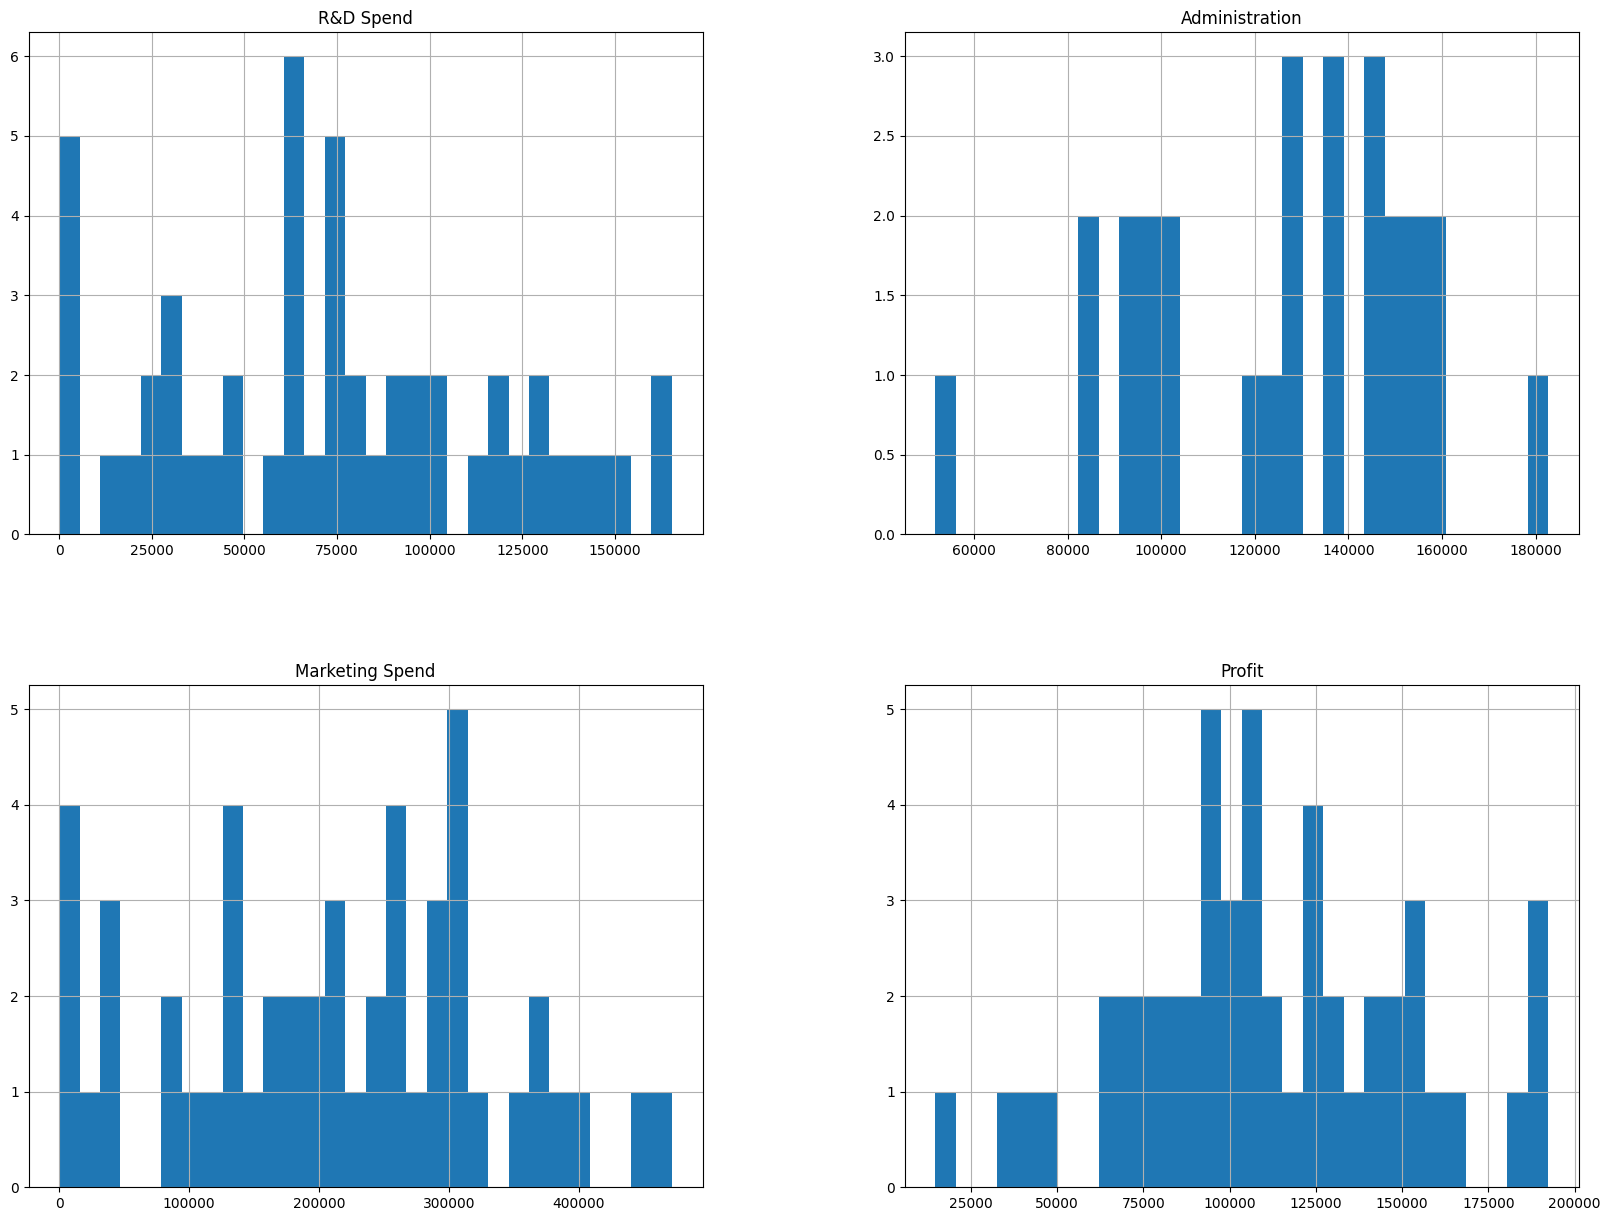

In [9]:
get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline

dataset.hist(bins = 30, figsize = (20,15))
plt.show()

Из представленых графиков неясно, близко ли распределние данных в выборке к нормальному распределению.
##### Постоим графики плотности для дополнительной визуализации данных.

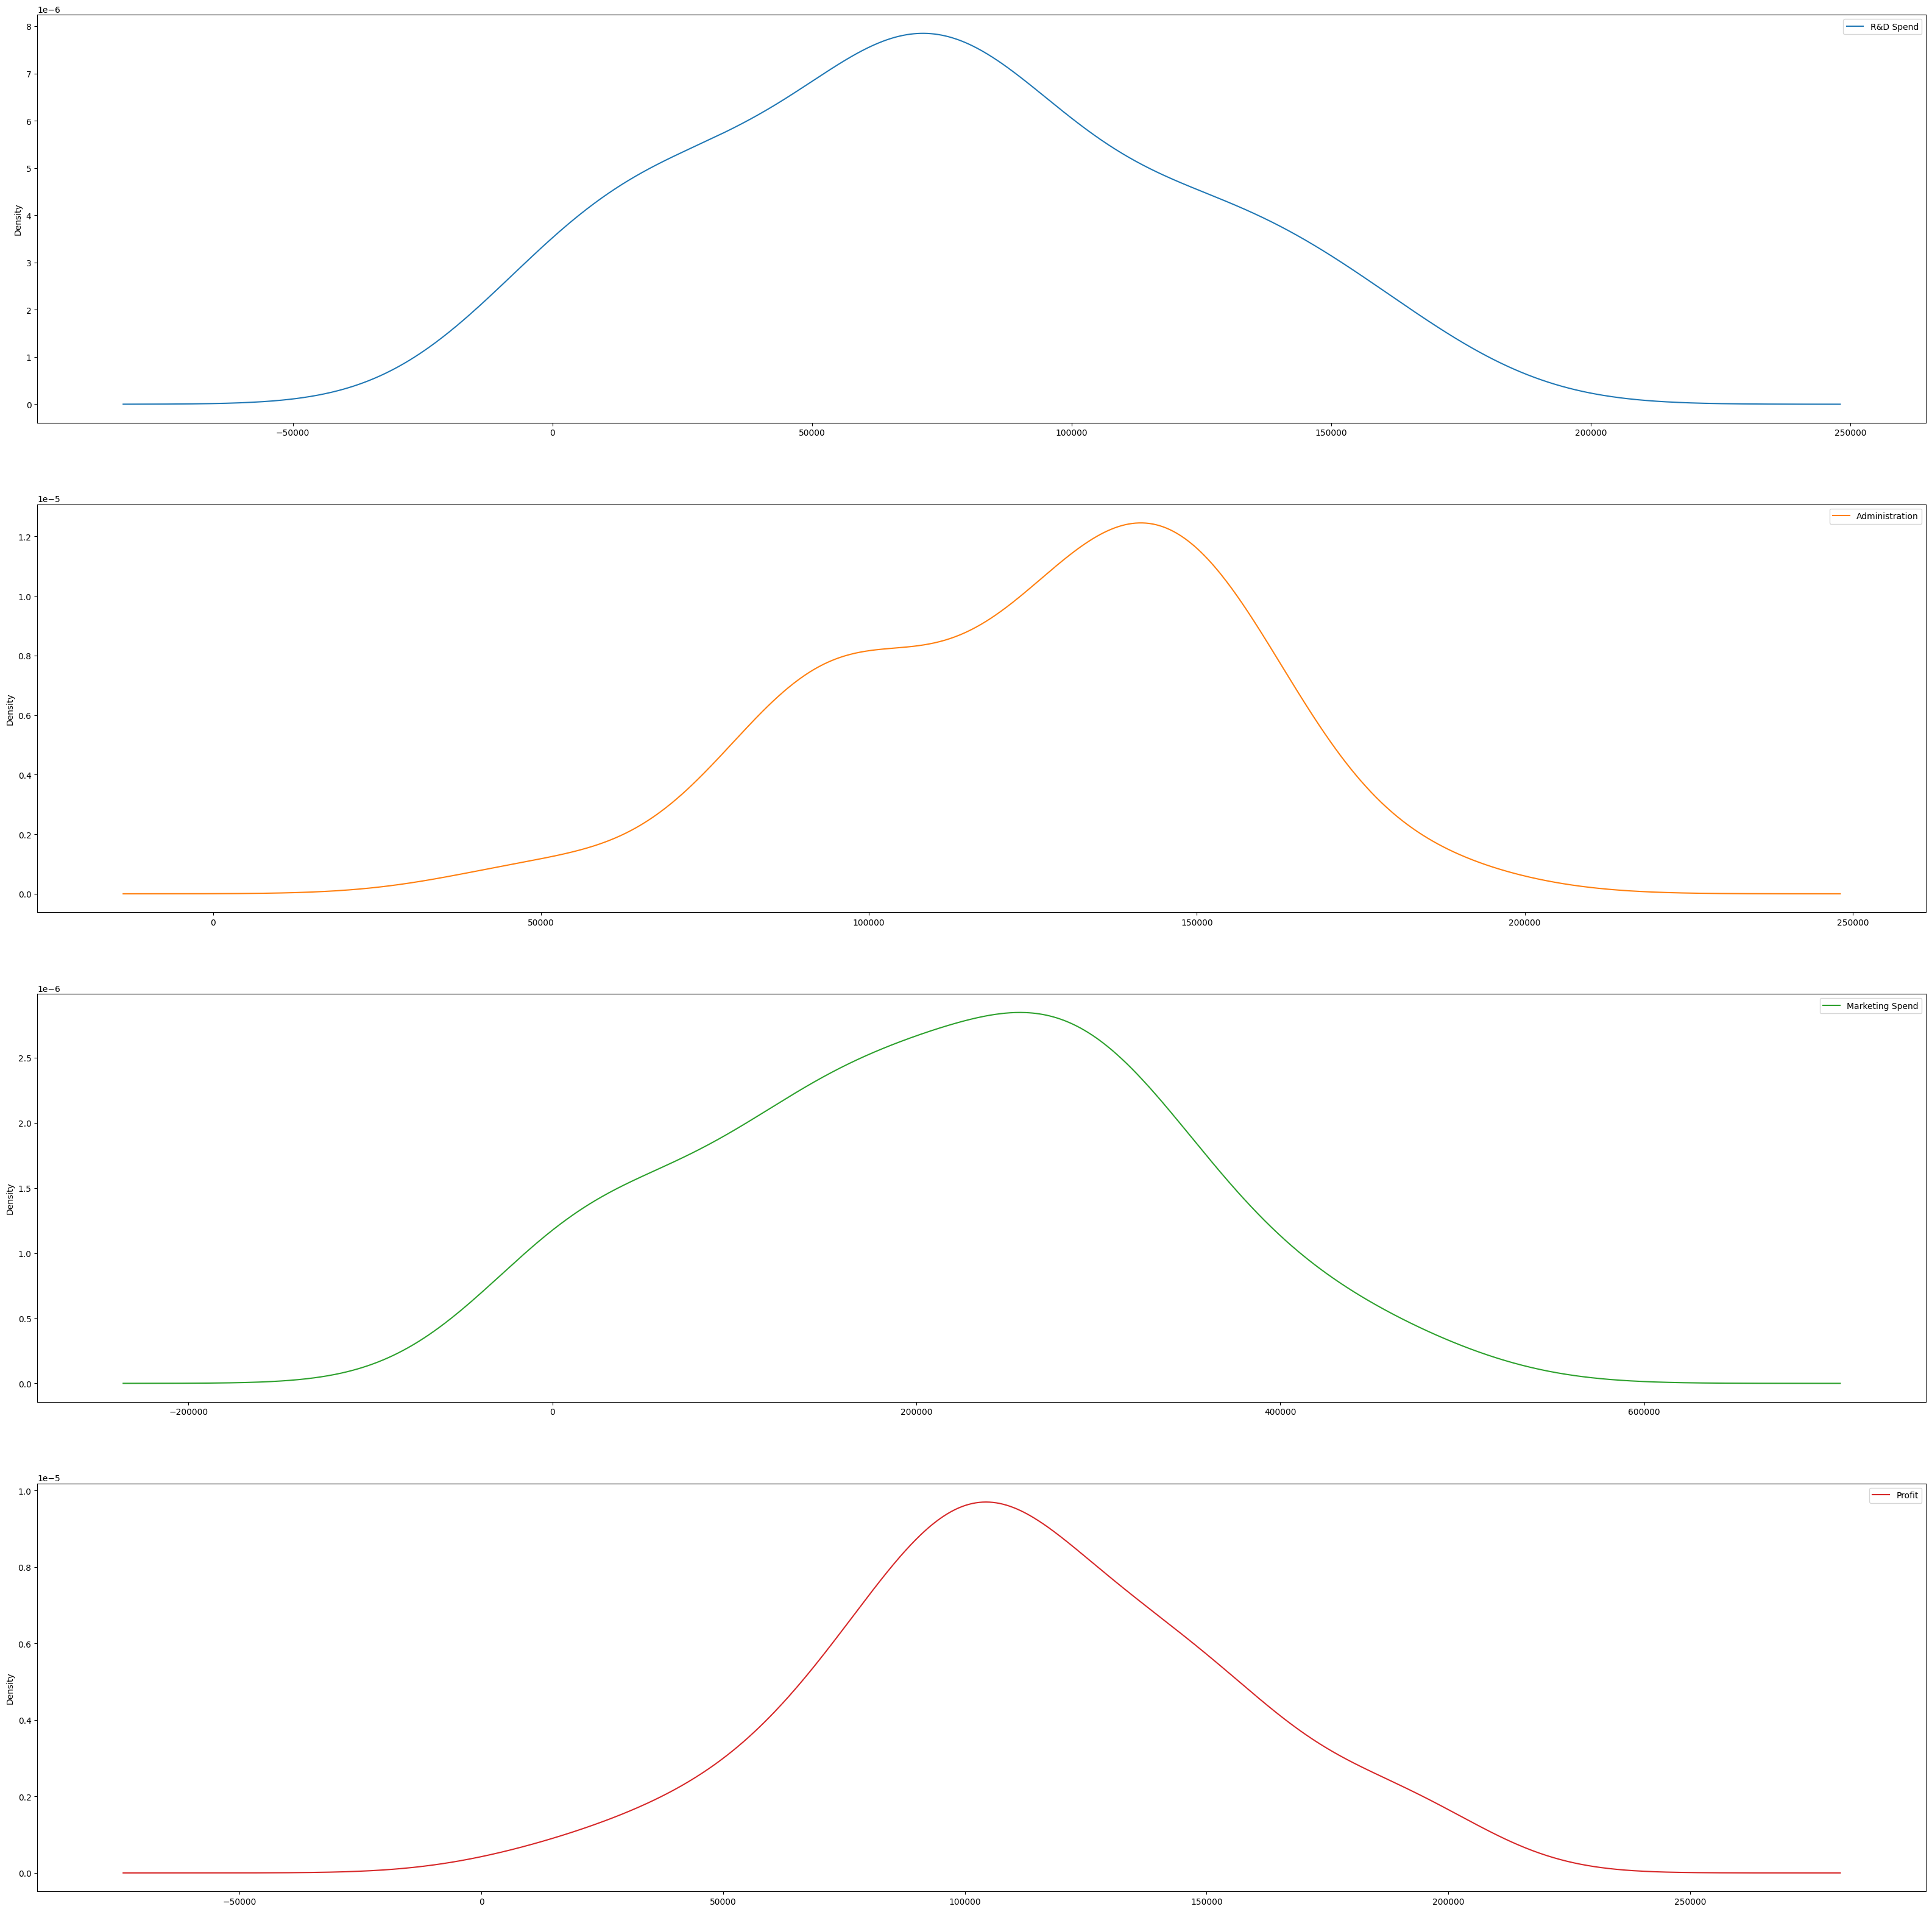

In [10]:
dataset.plot(kind="density", subplots=True, sharex=False, figsize=(40,40))
plt.show()

Графики плотности близки к колоколу, что косвенно может указывать на нормальное распределение.

### Многомерная

##### Построение матрицы диаграммы рассеяния.

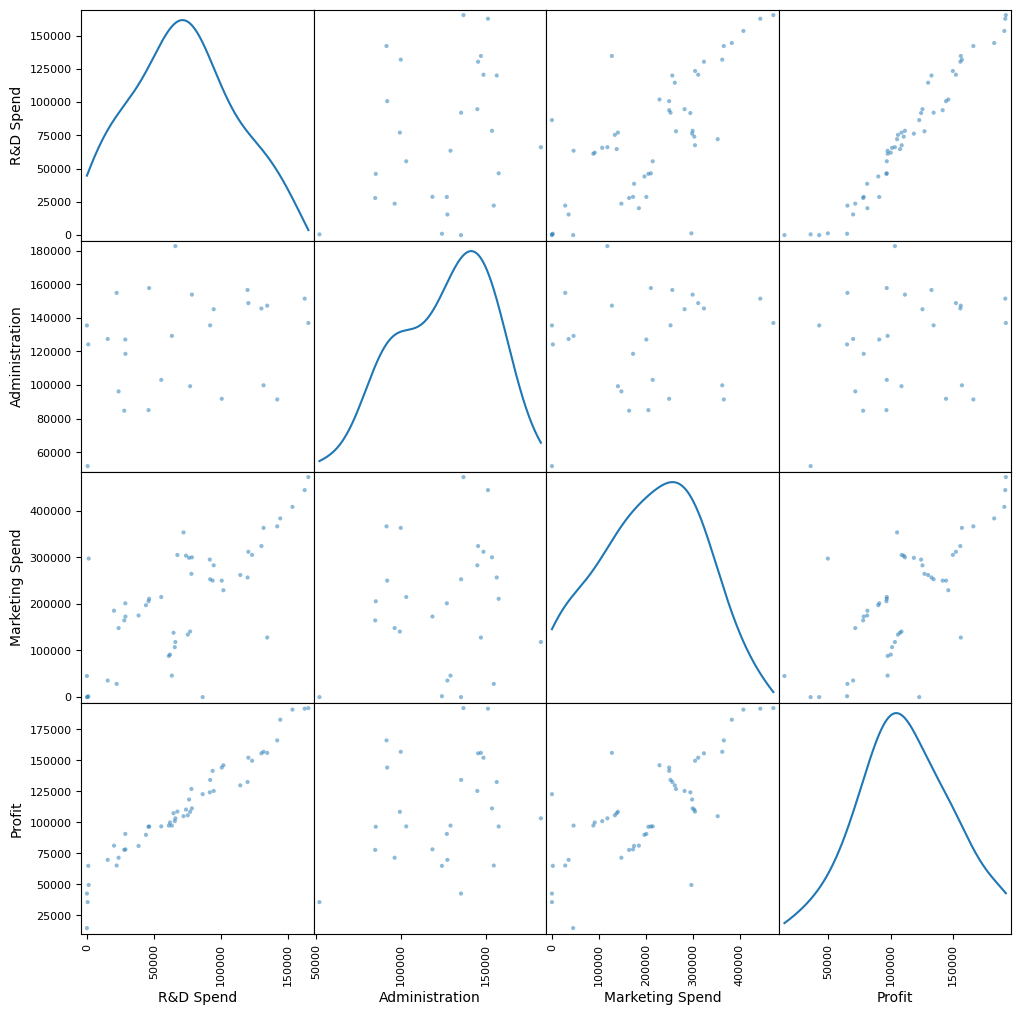

In [11]:
scatter_matrix(dataset, figsize=(12,12), diagonal='density')
plt.show()

##### Построение корреляционной матрицы (без строкового атрибута State).

In [12]:
# Сохраним категориальный атрибут в виде отдельного столбца
dataset_states = dataset["State"]

In [13]:
# Удалим категориальный атрибут State из набора данных
dataset = dataset.drop("State", axis=1)

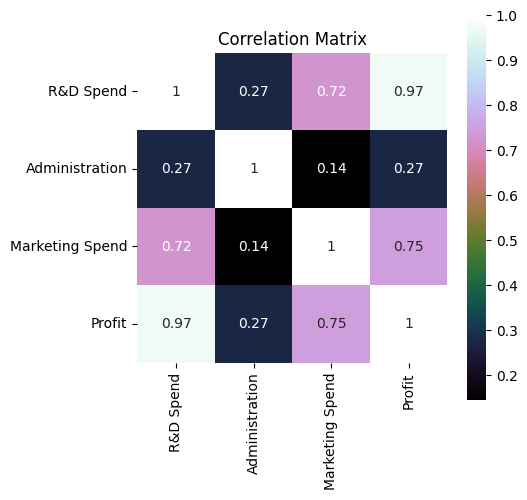

In [14]:
dataset_corr = dataset.corr()
plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(dataset_corr, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.show()

---
## 3.3. Поиск корреляционной зависимости между признаками
##### Вычисление стандартного коэффициента корреляции (Пирсона)

In [15]:
dataset_corr

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000,0.274,0.724,0.973
Administration,0.274,1.000,0.145,0.272
Marketing Spend,0.724,0.145,1.000,0.748
Profit,0.973,0.272,0.748,1.000


<br>
Просмотр данных по конкретному атрибуту ('Profit').

In [16]:
dataset_corr["Profit"].sort_values(ascending=False)

,Profit
Profit,1.000
R&D Spend,0.973
Marketing Spend,0.748
Administration,0.272


Видно, что все атрибуты достаточно сильно связаны с прибылью(Profit). Кроме Administration.

---
---
# 4. Подготовка данных

---
## 4.1. Очистка данных

##### Восполним недостающие данные
Так как атрибут Administration имеет много нечисловых значений (NaN), заполним вместо них случайные значения около медианы с разбросом 10% от стандартного отклонения этого атрибута и заново вычислим стандартный коэффициент корреляции

In [17]:
# Определяем медиану и стандартное отклонение для столбца Administration
median_value = dataset['Administration'].median()
std_dev = dataset['Administration'].std() / 10 # Используем полное стандартное отклонение

# Функция для генерации случайных значений на основе стандартного отклонения
def random_fillna(x, median, std_dev):
    if np.isnan(x):
        return np.random.normal(median, std_dev)
    return x

# Применяем функцию к столбцу Administration
dataset['Administration'] = dataset['Administration'].apply(random_fillna, args=(median_value, std_dev))

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   Profit           50 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


Теперь все данные в полном объеме.

---
## 4.2. Обработка текстовых и категориальных атрибутов

Ранее мы отделили категориальный атрибут State из набора данных, он хранится в виде series в переменной dataset_states.

In [18]:
dataset_states.head(5)
# dataset["State"].value_counts()

,State
0,New York
1,California
2,Florida
3,New York
4,Florida


Преобразуем категории в числа путем кодирования с одним активным состоянием (one-hot encoding).

In [19]:
from sklearn.preprocessing import OneHotEncoder
def categorized(dataset, dataset_states):
    hot_encoder = OneHotEncoder()

    # Преобразуем в двумерный массив
    dataset_states = np.array(dataset_states).reshape(-1, 1)

    states_1hot = hot_encoder.fit_transform(dataset_states)

    # Преобразуем разреженную матрицу в DataFrame
    states_1hot_df = pd.DataFrame(states_1hot.toarray(), columns=hot_encoder.get_feature_names_out(['State']))

    # Добавляем к исходному датасету
    dataset_changed = pd.concat([dataset, states_1hot_df], axis=1)
    return dataset_changed
# Печать результата
print(categorized(dataset, dataset_states).head())

   R&D Spend  Administration  Marketing Spend     Profit  State_California  \
0  165349.20      136897.800        471784.10  192261.83               0.0   
1  162597.70      151377.590        443898.53  191792.06               1.0   
2  153441.51      124892.092        407934.54  191050.39               0.0   
3  144372.41      126174.851        383199.62  182901.99               0.0   
4  142107.34       91391.770        366168.42  166187.94               0.0   

   State_Florida  State_New York  
0            0.0             1.0  
1            0.0             0.0  
2            1.0             0.0  
3            0.0             1.0  
4            1.0             0.0  


Возвращаем в наш набор данных атрибут State в числовом виде.

In [20]:
dataset = categorized(dataset, dataset_states)

In [21]:
# dataset.head()

---
## 4.3. Отбор существенных (информативных) признаков

##### Проведем оценку признаков используя библиотеку SkLearn

In [22]:
data_x = pd.concat([dataset.iloc[:, :3], dataset.iloc[:, -3:]], axis=1)
data_y = dataset["Profit"]
best_features = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k="all")
fit = best_features.fit(data_x, data_y)
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(data_x.columns)
feature_scores = pd.concat([columns, scores], axis = 1)
feature_scores


,0,0
0,R&D Spend,849.789
1,Administration,1.690
2,Marketing Spend,60.881
3,State_California,1.043
4,State_Florida,0.657
5,State_New York,0.047


In [23]:
dataset_corr = dataset.corr()
dataset_corr["Profit"].sort_values(ascending=False)

,Profit
Profit,1.000
R&D Spend,0.973
Marketing Spend,0.748
Administration,0.184
State_Florida,0.116
State_New York,0.031
State_California,-0.146


##### Определим несущественные признаки
Из полученных данных видно, что категориальный атрибут State и атрибут Administration слабо влияют на признак Profit. Поэтому отметим эти признаки как неинформативные и не будем их включать в очищенные наборы данных (dataset_pure и dataset_pure_normalize).

---
## 4.4. Преобразование данных. Нормализация.

##### Функция нормализации

In [24]:
def normalize_dataset(dataset):
    numeric_columns = dataset.select_dtypes(include=[np.number]).columns  # Выбираем только числовые столбцы
    scaler = StandardScaler()
    dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])
    return dataset

##### Сформируем 4 набора данных (по заданию):
*   Базовый с категориальным атрибутом
*   Базовый с категориальным атрибутом, нормализованный
*   Набор данных с информативными признаками
*   Набор данных с информативными признаками, нормализованный




In [25]:
# dataset сейчас состоит из R&D Spend, Administration, Marketing Spend, Profit, State
dataset_basic = dataset
dataset_pure = dataset.drop(["Administration", "State_California", "State_Florida", "State_New York"], axis=1)
dataset_basic_normalize = normalize_dataset(dataset_basic)
dataset_pure_normalize = normalize_dataset(dataset_pure)

In [26]:
#dataset_basic.head()
#dataset_pure.head()
#dataset_basic_normalize.head()
#dataset_pure_normalize.head()

---
---
# 5. Оценка моделей

---
## 5.1 Разделение набора данных на обучающий и тестовый наборы

##### Функция получения наборов из базового набора с категориальным атрибутом

In [27]:
def get_basic_train_test_and_val_data():
    # Разделение данных на признаки (sheet_x) и целевую переменную (sheet_y) с использованием iloc
    sheet_x = dataset_basic.iloc[:, [0, 1, 2, 4, 5, 6]]  # Выбор нужных столбцов с использованием индексации
    sheet_y = dataset_basic.iloc[:, 3]  #  'Profit' находится в 4 столбце

    # Определение случайного состояния (seed) и размеров тестового и валидационного наборов
    seed = 7
    test_size = 0.2
    val_size = 0.25

    # Разделение данных на обучающие и тестовые наборы
    x_train, x_test, y_train, y_test = train_test_split(sheet_x, sheet_y, test_size=test_size, random_state=seed)

    # Разделение обучающих данных на обучающие и валидационные наборы
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)

    return x_train, y_train, x_test, y_test, x_val, y_val

basic_x_train, basic_y_train, basic_x_test, basic_y_test, basic_x_val, basic_y_val = get_basic_train_test_and_val_data()
print("basic_x_train\n",basic_x_train.head())
print("basic_y_train\n",basic_y_train.head())

basic_x_train
     R&D Spend  Administration  Marketing Spend  State_California  \
8       1.030           1.006            0.831            -0.718   
40     -0.990          -0.371           -0.316             1.393   
31     -0.277          -0.175           -1.014            -0.718   
26      0.035           0.324           -0.636            -0.718   
35     -0.610          -1.901           -0.045            -0.718   

    State_Florida  State_New York  
8          -0.686           1.393  
40         -0.686          -0.718  
31         -0.686           1.393  
26          1.458          -0.718  
35         -0.686           1.393  
basic_y_train
 8     1.007
40   -0.846
31   -0.364
26   -0.157
35   -0.389
Name: Profit, dtype: float64


---
## 5.2. Разделение набора данных на обучающую, проверяющую-валидационную и тестовую выборки
Используя модуль Scikit-Learn разделим наш набор данных на 3 выборки.

###### Реализуем функции для разделения наборов данных на 3 выборки

In [28]:


def get_pure_train_test_and_val_data():
    # Разделение данных на признаки (sheet_x) и целевую переменную (sheet_y) с использованием iloc
    sheet_x = dataset_pure.iloc[:, [0, 1]]  # Выбор нужных столбцов с использованием индексации
    sheet_y = dataset_pure.iloc[:, 2]  #  'Profit' находится в 4 столбце

    # Определение случайного состояния (seed) и размеров тестового и валидационного наборов
    seed = 7
    test_size = 0.2
    val_size = 0.25

    # Разделение данных на обучающие и тестовые наборы
    x_train, x_test, y_train, y_test = train_test_split(sheet_x, sheet_y, test_size=test_size, random_state=seed)

    # Разделение обучающих данных на обучающие и валидационные наборы
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)

    return x_train, y_train, x_test, y_test, x_val, y_val

def get_basic_normalize_train_test_and_val_data():
    # Разделение данных на признаки (sheet_x) и целевую переменную (sheet_y) с использованием iloc
    sheet_x = dataset_basic_normalize.iloc[:, [0, 1, 2, 4, 5, 6]]  # Выбор нужных столбцов с использованием индексации
    sheet_y = dataset_basic_normalize.iloc[:, 3]  #  'Profit' находится в 4 столбце

    # Определение случайного состояния (seed) и размеров тестового и валидационного наборов
    seed = 7
    test_size = 0.2
    val_size = 0.25

    # Разделение данных на обучающие и тестовые наборы
    x_train, x_test, y_train, y_test = train_test_split(sheet_x, sheet_y, test_size=test_size, random_state=seed)

    # Разделение обучающих данных на обучающие и валидационные наборы
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)

    return x_train, y_train, x_test, y_test, x_val, y_val

def get_pure_normalize_train_test_and_val_data():
    # Разделение данных на признаки (sheet_x) и целевую переменную (sheet_y) с использованием iloc
    sheet_x = dataset_pure_normalize.iloc[:, [0, 1]]  # Выбор нужных столбцов с использованием индексации
    sheet_y = dataset_pure_normalize.iloc[:, 2]  #  'Profit' находится в 4 столбце

    # Определение случайного состояния (seed) и размеров тестового и валидационного наборов
    seed = 7
    test_size = 0.2
    val_size = 0.25

    # Разделение данных на обучающие и тестовые наборы
    x_train, x_test, y_train, y_test = train_test_split(sheet_x, sheet_y, test_size=test_size, random_state=seed)

    # Разделение обучающих данных на обучающие и валидационные наборы
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)

    return x_train, y_train, x_test, y_test, x_val, y_val



In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import LSTM, Dense, Input

for data_function in [
    get_basic_train_test_and_val_data,
    get_pure_train_test_and_val_data,
    get_basic_normalize_train_test_and_val_data,
    get_pure_normalize_train_test_and_val_data]:

    x_train, y_train, x_test, y_test, x_val, y_val = data_function()
    model = Sequential(
        [
            keras.layers.Input(shape=(x_train.shape[1],)),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(1),
        ]
    )
    print("Dense Model")
    model.compile(optimizer="rmsprop", loss="mse")

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, verbose=0)

    y_train_pred = model.predict(x_train, verbose=0)
    y_test_pred = model.predict(x_test, verbose=0)
    y_val_pred = model.predict(x_val, verbose=0)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val = r2_score(y_val, y_val_pred)

    print(f"Data function: {data_function.__name__}:\nTrain RMSE = {rmse_train}, Train R² = {r2_train}")
    print(f"Test RMSE = {rmse_test}, Test R² = {r2_test}")
    print(f"Validation RMSE = {rmse_val}, Validation R² = {r2_val}")

    with open('output.txt', 'a+') as output_file:
        output_file.write(f"Data function: {data_function.__name__}\n")
        output_file.write(f"Train RMSE for RMM: {rmse_train}\n")
        output_file.write(f"Train R2 Score for RMM: {r2_train}\n")
        output_file.write(f"Test RMSE for RMM: {rmse_test}\n")
        output_file.write(f"Test R2 Score for RMM: {r2_test}\n")
        output_file.write(f"Valid RMSE for RMM: {rmse_val}\n")
        output_file.write(f"Valid R2 Score for RMM: {r2_val}\n")

    print("LSTM Model")
    # LSTM
    # Преобразуйте ваши DataFrame в массивы numpy
    x_train_array = x_train.values
    x_val_array = x_val.values
    x_test_array = x_test.values

    #Примените метод reshape
    x_train_reshaped = x_train_array.reshape((x_train_array.shape[0], x_train_array.shape[1], 1))
    x_val_reshaped = x_val_array.reshape((x_val_array.shape[0], x_val_array.shape[1], 1))
    x_test_reshaped = x_test_array.reshape((x_test_array.shape[0], x_test_array.shape[1], 1))


    model = Sequential(
        [
            Input(shape=(x_train.shape[1], 1)),
            LSTM(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(1),
        ]
    )

    model.compile(optimizer="rmsprop", loss="mse")

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, verbose=0)

    y_train_pred = model.predict(x_train, verbose=0)
    y_test_pred = model.predict(x_test, verbose=0)
    y_val_pred = model.predict(x_val, verbose=0)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val = r2_score(y_val, y_val_pred)

    print(f"Data function: {data_function.__name__}:\nTrain RMSE = {rmse_train}, Train R² = {r2_train}")
    print(f"Test RMSE = {rmse_test}, Test R² = {r2_test}")
    print(f"Validation RMSE = {rmse_val}, Validation R² = {r2_val}")
    with open('output.txt', 'a+') as output_file:
        output_file.write('\n')
        output_file.write(f"Data function: {data_function.__name__}\n")
        output_file.write(f"Train RMSE for LIN: {rmse_train}\n")
        output_file.write(f"Train R2 Score for LIN: {r2_train}\n")
        output_file.write(f"Test RMSE for LIN: {rmse_test}\n")
        output_file.write(f"Test R2 Score for LIN: {r2_test}\n")
        output_file.write(f"Valid RMSE for LIN: {rmse_val}\n")
        output_file.write(f"Valid R2 Score for LIN: {r2_val}\n\n")
        output_file.write("#################################\n\n")



Dense Model
Data function: get_basic_train_test_and_val_data:
Train RMSE = 0.11574890752553668, Train R² = 0.9868158767162147
Test RMSE = 0.2945090067147837, Test R² = 0.8628987106276034
Validation RMSE = 0.29160228338463023, Validation R² = 0.929350262127931
LSTM Model
Data function: get_basic_train_test_and_val_data:
Train RMSE = 0.3005561114727723, Train R² = 0.9111067917562544
Test RMSE = 0.28620998437044776, Test R² = 0.8705166469820472
Validation RMSE = 0.7611167053111461, Validation R² = 0.5186829765155923
Dense Model


Data function: get_pure_train_test_and_val_data:
Train RMSE = 0.11894896581844888, Train R² = 0.9860768085472668
Test RMSE = 0.17244555477112705, Test R² = 0.9529945315934854
Validation RMSE = 0.42891651582314455, Validation R² = 0.8471468993097265
LSTM Model
Data function: get_pure_train_test_and_val_data:
Train RMSE = 0.18276248731261022, Train R² = 0.9671306153300262
Test RMSE = 0.29344666485802134, Test R² = 0.863886019987971
Validation RMSE = 0.497635387402155, Validation R² = 0.7942446075986939
Dense Model
Data function: get_basic_normalize_train_test_and_val_data:
Train RMSE = 0.0941740354888751, Train R² = 0.9912727017912689
Test RMSE = 0.29017791708565377, Test R² = 0.8669015201995188
Validation RMSE = 0.30427115391846604, Validation R² = 0.9230780514416714
LSTM Model
Data function: get_basic_normalize_train_test_and_val_data:
Train RMSE = 0.28437497419791036, Train R² = 0.9204206837730877
Test RMSE = 0.3527848600905754, Test R² = 0.8032728705198544
Validation RMSE = 0.8089274

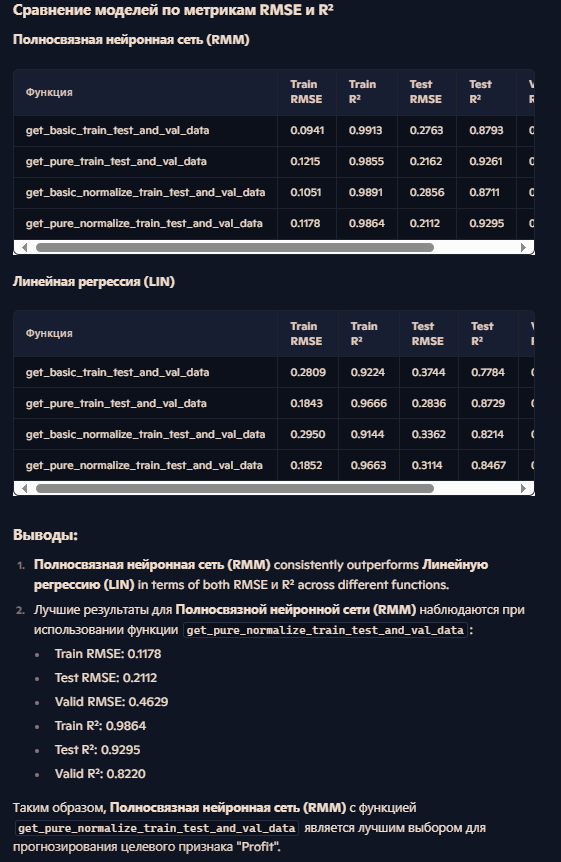

---
##5.3 Поиск гиперпараметров

In [30]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.8 MB/s eta 0:00:00


функции для поиска гиперпараметров для лучшей модели и лучшего датасета

In [31]:
import tensorflow as tf
import keras_tuner as kt
import sklearn.metrics
import numpy as np

# Строим модель с гиперпараметрами
def build_rmm_model(hp, input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(
            units=hp.Int(name="units1", min_value=32, max_value=128, step=16),
            activation="elu"
        ),
        tf.keras.layers.Dense(
            units=hp.Int(name="units2", min_value=32, max_value=128, step=16),
            activation="elu"
        ),
        tf.keras.layers.Dense(
            units=hp.Int(name="units3", min_value=32, max_value=128, step=16),
            activation="elu"
        ),
        tf.keras.layers.Dense(1, activation="linear"),  # линейная активация для регрессии
    ])

    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

def get_best_epoch(x_train, y_train, x_val, y_val, hp):
    model = build_rmm_model(hp, (x_train.shape[1],))  # Используем функцию для создания модели
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_root_mean_squared_error", patience=25),
        tf.keras.callbacks.ModelCheckpoint(
            monitor="val_root_mean_squared_error",
            filepath="best_epoch_model.keras",
            save_best_only=True
        )
    ]

    history = model.fit(
        x_train, y_train, validation_data=(x_val, y_val), epochs=150,
        verbose=1, callbacks=callbacks
    )

    val_rmse_per_epoch = history.history["val_root_mean_squared_error"]  # Получаем метрики по эпохам
    best_epoch = val_rmse_per_epoch.index(min(val_rmse_per_epoch)) + 1  # Нахождение минимального RMSE
    print(f"Best epoch: {best_epoch}")  # Вывод лучшей эпохи

    return best_epoch


# Тюнинг модели с использованием Keras Tuner
def get_rmm_tuner(x_train, y_train, val_data):
    input_shape = (x_train.shape[1],)

    tuner = kt.BayesianOptimization(
        lambda hp: build_rmm_model(hp, input_shape),
        objective="val_root_mean_squared_error",  # оцениваем по RMSE на валидации
        max_trials=100,
        executions_per_trial=2,
        directory=".",
        overwrite=True,
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_root_mean_squared_error", patience=25),
        tf.keras.callbacks.ModelCheckpoint(
            monitor="val_root_mean_squared_error",
            filepath="rmm_model_best.keras",
            save_best_only=True,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=10),
    ]

    tuner.search(x_train, y_train, validation_data=val_data, epochs=150, verbose=1, callbacks=callbacks)

    return tuner

# Процесс тренировки модели с использованием лучшего тюнера
def process_rmm_dataset(x_train, y_train, x_val, y_val, x_test, y_test, tuner):
    title = "RMM Best model - Best dataset"

    hp = tuner.get_best_hyperparameters()[0]
    best_epoch = get_best_epoch(x_train, y_train, x_val, y_val, hp)
    model = build_rmm_model(hp, (x_train.shape[1],))

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            monitor="val_root_mean_squared_error",
            filepath=f"{title}.keras",
            save_best_only=True,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=10),
    ]

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=best_epoch, verbose=1)

    model.summary()

    val_rmse = min(history.history["val_root_mean_squared_error"])

    y_pred = model.predict(x_test, verbose=0)

    rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
    r2 = sklearn.metrics.r2_score(y_test, y_pred)

    print(f"{title}: RMSE = {rmse}, R2 = {r2}")


Дальше запустим это для лучшей модели например pure_normalize_train_test_and_val_data
### Вроде доделал

In [32]:
# Данные, которые вы подготовили
x_train, y_train, x_val, y_val, x_test, y_test = get_pure_normalize_train_test_and_val_data()

# Получаем тюнер для подбора гиперпараметров
tuner = get_rmm_tuner(x_train, y_train, (x_val, y_val))

# Обрабатываем данные и тренируем модель с использованием лучшего тюнера
process_rmm_dataset(x_train, y_train, x_val, y_val, x_test, y_test, tuner)


Trial 100 Complete [00h 00m 18s]
val_root_mean_squared_error: 0.24886301159858704

Best val_root_mean_squared_error So Far: 0.23887715488672256
Total elapsed time: 00h 26m 44s
Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6449 - root_mean_squared_error: 0.8031 - val_loss: 0.2848 - val_root_mean_squared_error: 0.5337
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3982 - root_mean_squared_error: 0.6310 - val_loss: 0.1816 - val_root_mean_squared_error: 0.4261
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.2283 - root_mean_squared_error: 0.4778 - val_loss: 0.1274 - val_root_mean_squared_error: 0.3569
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1348 - root_mean_squared_error: 0.3671 - val_loss: 0.1183 - val_root_mean_squared_error: 0.3440
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1091 - root_mean_squared_error: 0.3303 - val_loss: 0.1390 - val_root_mean_squared_error: 0.3728
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 48)                  │           6,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,933 (152.09 KB)

 Trainable params: 12,977 (50.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,956 (101.39 KB)

RMM Best model - Best dataset: RMSE = 0.25151272350608533, R2 = 0.9474408135743615


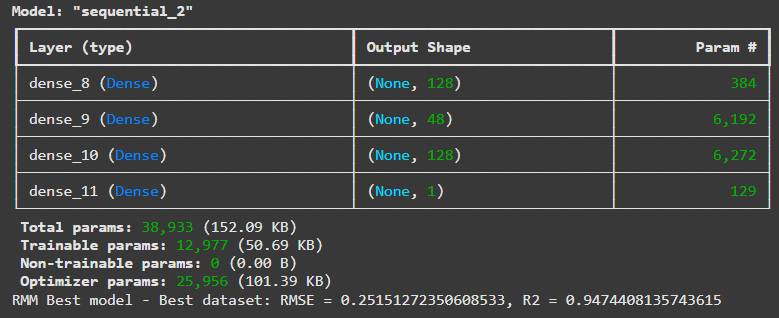